In [1]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
plt.style.use('seaborn')

# Repository imports.
import DataGenerator
import LocalNetBase
import network
import train

## Visualize random halfspace data

Note: For the clearest separation, set dim = 2 (we only plot the first two dimensions here).

points: (1000, 3) float64
labels: (1000,) bool


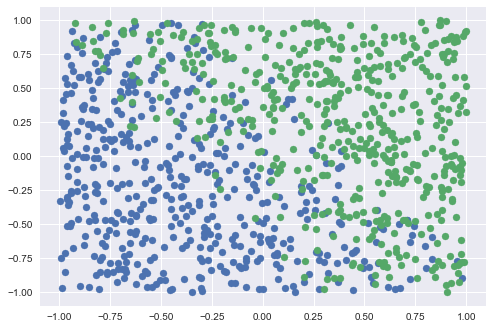

In [2]:
dim = 3
n = 1000
points, labels = DataGenerator.random_halfspace_data(dim, n)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels
zeros = np.invert(labels)
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize random ReLU data

Note: Sometimes, all points end up having the same label.

points: (1000, 2) float32
labels: (1000,) int64


..\DataGenerator.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out2 = F.softmax(torch.matmul(out1, w1))


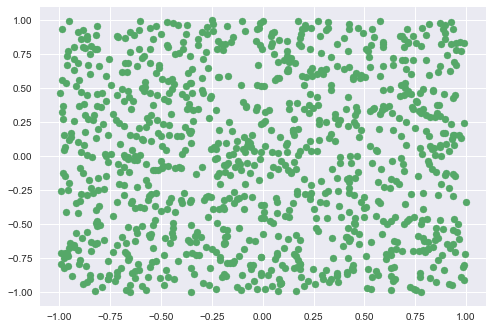

In [3]:
dim = 2
n = 1000
k = 10
points, labels = DataGenerator.layer_relu_data(dim, n, k)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels.astype(np.bool)
zeros = np.invert(ones)
# ax.scatter(points[:, 0][ones], points[:, 1][ones], labels[ones])
# ax.scatter(points[:, 0][zeros], points[:, 1][zeros], labels[zeros])
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize MNIST

In [4]:
import torchvision
import torchvision.datasets
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
print('mnist_train:', len(mnist_train))
print('mnist_test:', len(mnist_test))

mnist_train: 60000
mnist_test: 10000


In [5]:
X = np.array([np.array(pair[0]) for pair in mnist_train]) / 255.0
y = np.array([pair[1] for pair in mnist_train])
X_test = np.array([np.array(pair[0]) for pair in mnist_test]) / 255.0
y_test = np.array([pair[1] for pair in mnist_test])
print('X:', X.shape)
print('y:', y.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
mnist_X, mnist_y, mnist_X_test, mnist_y_test = X, y, X_test, y_test

X: (60000, 28, 28)
y: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


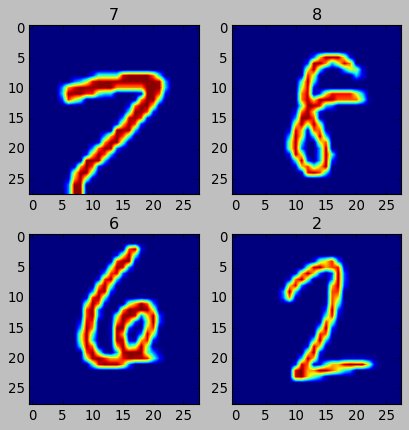

In [6]:
plt.style.use('classic')
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(X[123])
ax[0, 0].set_title(y[123])
ax[0, 1].imshow(X[456])
ax[0, 1].set_title(y[456])
ax[1, 0].imshow(X_test[123])
ax[1, 0].set_title(y_test[123])
ax[1, 1].imshow(X_test[456])
ax[1, 1].set_title(y_test[456])
plt.show()
plt.style.use('seaborn')

## Instantiate and inspect RNN

This is based on the README. Notes:

* The "rounds" parameter seems to be defined as T-1, so rounds=1 <=> T=2!

* The word "graph" in the code refers to the recurrent portion of the RNN, i.e. the randomly, sparsely connected part, excluding input and output neurons.

* I'm not sure as to what the best options are for which scenario, feel free to experiment with this.

In [7]:
options = LocalNetBase.Options(
    use_input_rule = False,    # Use an input rule to update input layer weights.
    use_output_rule = False,   # Use an output rule to update input layer weights.
    gd_output_rule = False,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    use_graph_rule = True,
    gd_graph_rule = True,
    gd_input = False,          # gd directly on input layer weights.
    gd_output = False,         # gd directly on output layer weights.
    additive_rule = True)      # If false, uses multiplicative updates.

scheme = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      # By default, uses cross entropy loss.
    mse_loss = False,
    update_misclassified_only = True,    # By default only update weights when we misclassify.
    update_all_edges = False)       # For output rule, update all edges, or only edge to correct and predicted label.

local_net = network.LocalNet(n = 4,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
    
print('local_net input_rule:')
print(local_net.input_rule)  # 2^T, randomly initialized
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # 2^T x 2^T, randomly initialized
print('local_net output_rule:')
print(local_net.get_output_rule())  # 2^T x 2, all zero

local_net input_rule:
tensor([ 0.4496, -0.5257,  0.9094,  1.1495])
local_net rnn_rule:
tensor([[-0.7135, -1.3227, -0.6778, -0.2959],
        [-0.5211,  0.4737, -1.1110,  1.1580],
        [ 1.1259, -0.5689, -0.7582, -0.2768],
        [ 1.5171, -1.0756, -0.4333, -1.8753]])
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Meta-learn rules using gradient descent on halfspace

  0%|                  | 0/20 [00:00<?, ?it/s]

Start meta-learning over outer (rule) epochs...


  5%|▌         | 1/20 [00:02<00:43,  2.29s/it]

Acc of class 0 : 0.3504
Acc of class 1 : 0.6494
Train accuracy: 0.5030
Acc of class 0 : 0.2888
Acc of class 1 : 0.6185
Test accuracy: 0.4530
Current loss: 0.6935
Mean loss so far: 0.6935


 10%|█         | 2/20 [00:04<00:41,  2.30s/it]

Acc of class 0 : 0.3718
Acc of class 1 : 0.6366
Train accuracy: 0.5070
Acc of class 0 : 0.3187
Acc of class 1 : 0.6305
Test accuracy: 0.4740
Current loss: 0.6975
Mean loss so far: 0.6955


 15%|█▌        | 3/20 [00:06<00:38,  2.29s/it]

Acc of class 0 : 0.5679
Acc of class 1 : 0.7973
Train accuracy: 0.6850
Acc of class 0 : 0.5239
Acc of class 1 : 0.8153
Test accuracy: 0.6690
Current loss: 0.6802
Mean loss so far: 0.6904


 20%|██        | 4/20 [00:09<00:36,  2.29s/it]

Acc of class 0 : 0.5434
Acc of class 1 : 0.7453
Train accuracy: 0.6465
Acc of class 0 : 0.5080
Acc of class 1 : 0.7209
Test accuracy: 0.6140
Current loss: 0.6687
Mean loss so far: 0.6850


 25%|██▌       | 5/20 [00:11<00:34,  2.29s/it]

Acc of class 0 : 0.4862
Acc of class 1 : 0.7062
Train accuracy: 0.5985
Acc of class 0 : 0.4980
Acc of class 1 : 0.7269
Test accuracy: 0.6120
Current loss: 0.6548
Mean loss so far: 0.6789


 30%|███       | 6/20 [00:13<00:31,  2.27s/it]

Acc of class 0 : 0.3166
Acc of class 1 : 0.7835
Train accuracy: 0.5550
Acc of class 0 : 0.2968
Acc of class 1 : 0.7811
Test accuracy: 0.5380
Current loss: 0.6416
Mean loss so far: 0.6727


 35%|███▌      | 7/20 [00:15<00:29,  2.25s/it]

Acc of class 0 : 0.1471
Acc of class 1 : 0.9618
Train accuracy: 0.5630
Acc of class 0 : 0.1375
Acc of class 1 : 0.9498
Test accuracy: 0.5420
Current loss: 0.6107
Mean loss so far: 0.6639


 40%|████      | 8/20 [00:18<00:26,  2.21s/it]

Acc of class 0 : 0.5945
Acc of class 1 : 0.8599
Train accuracy: 0.7300
Acc of class 0 : 0.5538
Acc of class 1 : 0.8635
Test accuracy: 0.7080
Current loss: 0.5966
Mean loss so far: 0.6555


 45%|████▌     | 9/20 [00:20<00:23,  2.16s/it]

Acc of class 0 : 0.6639
Acc of class 1 : 0.9990
Train accuracy: 0.8350
Acc of class 0 : 0.6235
Acc of class 1 : 0.9980
Test accuracy: 0.8100
Current loss: 0.5533
Mean loss so far: 0.6441


 50%|████▌    | 10/20 [00:22<00:21,  2.12s/it]

Acc of class 0 : 0.4576
Acc of class 1 : 0.9452
Train accuracy: 0.7065
Acc of class 0 : 0.4482
Acc of class 1 : 0.9538
Test accuracy: 0.7000
Current loss: 0.5409
Mean loss so far: 0.6338


 55%|████▉    | 11/20 [00:24<00:18,  2.11s/it]

Acc of class 0 : 0.4178
Acc of class 1 : 0.9197
Train accuracy: 0.6740
Acc of class 0 : 0.3924
Acc of class 1 : 0.9237
Test accuracy: 0.6570
Current loss: 0.5394
Mean loss so far: 0.6252


 60%|█████▍   | 12/20 [00:26<00:16,  2.10s/it]

Acc of class 0 : 0.5679
Acc of class 1 : 0.8981
Train accuracy: 0.7365
Acc of class 0 : 0.5538
Acc of class 1 : 0.9177
Test accuracy: 0.7350
Current loss: 0.5225
Mean loss so far: 0.6166


 65%|█████▊   | 13/20 [00:28<00:14,  2.11s/it]

Acc of class 0 : 0.4903
Acc of class 1 : 1.0000
Train accuracy: 0.7505
Acc of class 0 : 0.4841
Acc of class 1 : 1.0000
Test accuracy: 0.7410
Current loss: 0.5517
Mean loss so far: 0.6116


 70%|██████▎  | 14/20 [00:30<00:12,  2.10s/it]

Acc of class 0 : 0.7181
Acc of class 1 : 0.9207
Train accuracy: 0.8215
Acc of class 0 : 0.6892
Acc of class 1 : 0.9257
Test accuracy: 0.8070
Current loss: 0.5360
Mean loss so far: 0.6062


 75%|██████▊  | 15/20 [00:32<00:10,  2.09s/it]

Acc of class 0 : 0.4147
Acc of class 1 : 0.9471
Train accuracy: 0.6865
Acc of class 0 : 0.3904
Acc of class 1 : 0.9639
Test accuracy: 0.6760
Current loss: 0.5482
Mean loss so far: 0.6024


 80%|███████▏ | 16/20 [00:34<00:08,  2.07s/it]

Acc of class 0 : 0.7017
Acc of class 1 : 0.9275
Train accuracy: 0.8170
Acc of class 0 : 0.6594
Acc of class 1 : 0.9438
Test accuracy: 0.8010
Current loss: 0.5130
Mean loss so far: 0.5968


 85%|███████▋ | 17/20 [00:36<00:06,  2.08s/it]

Acc of class 0 : 0.7048
Acc of class 1 : 0.9207
Train accuracy: 0.8150
Acc of class 0 : 0.6873
Acc of class 1 : 0.9277
Test accuracy: 0.8070
Current loss: 0.5279
Mean loss so far: 0.5927


 90%|████████ | 18/20 [00:38<00:04,  2.09s/it]

Acc of class 0 : 0.8682
Acc of class 1 : 0.9373
Train accuracy: 0.9035
Acc of class 0 : 0.8386
Acc of class 1 : 0.9498
Test accuracy: 0.8940
Current loss: 0.5179
Mean loss so far: 0.5886


 95%|████████▌| 19/20 [00:40<00:02,  2.10s/it]

Acc of class 0 : 0.7640
Acc of class 1 : 0.9608
Train accuracy: 0.8645
Acc of class 0 : 0.7490
Acc of class 1 : 0.9679
Test accuracy: 0.8580
Current loss: 0.5401
Mean loss so far: 0.5860


100%|█████████| 20/20 [00:42<00:00,  2.15s/it]

Acc of class 0 : 0.4801
Acc of class 1 : 0.8639
Train accuracy: 0.6760
Acc of class 0 : 0.4841
Acc of class 1 : 0.8635
Test accuracy: 0.6730
Current loss: 0.5421
Mean loss so far: 0.5838


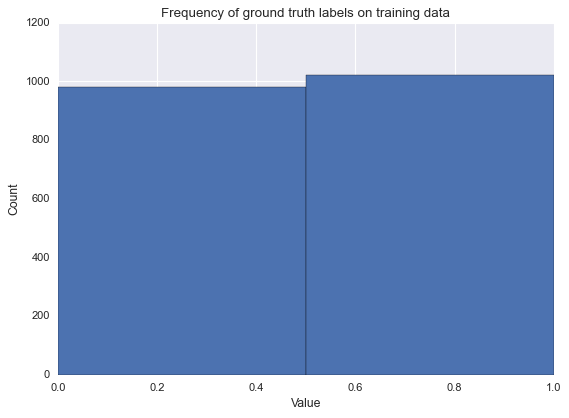

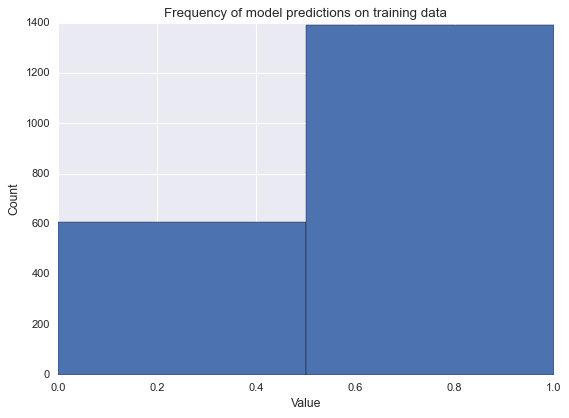

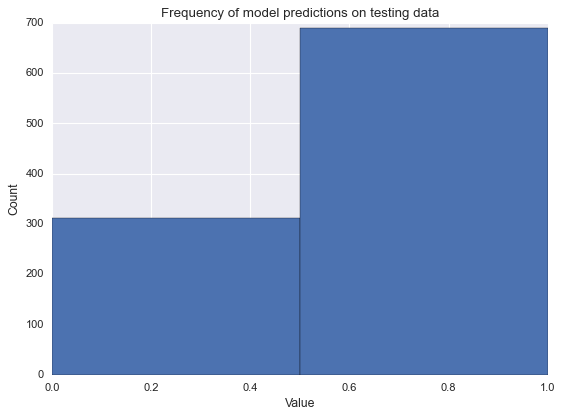

Last loss: 0.5421
Last train accuracy: 0.6760
Last test accuracy: 0.6730


In [8]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Meta-learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X,                      # Training inputs
    y,                      # Training labels
    local_net,              # The BrainNet
    num_rule_epochs = 20,   # Number of meta-learning epochs
    num_epochs = 2,         # Number of times to process a single batch
    batch_size = 100,       # Number of samples in a batch
    learn_rate = 1e-2,      # Learning rate
    X_test = X_test,
    y_test = y_test,
    verbose = True)

In [9]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.5421
Last train accuracy: 0.6760
Last test accuracy: 0.6730


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


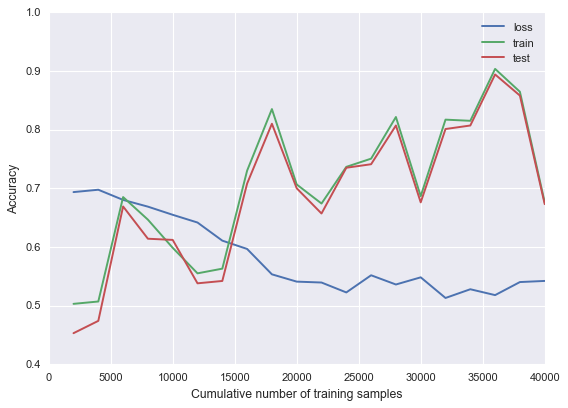

In [10]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Print rules.
print('local_net input_rule:')
print(local_net.input_rule)  # Same as before (cannot be learned?).
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # Learned.
print('local_net output_rule:')
print(local_net.get_output_rule())  # Same as before (we specified not to learn this).

local_net input_rule:
tensor([ 0.4496, -0.5257,  0.9094,  1.1495])
local_net rnn_rule:
tensor([[ 0.2044, -0.1127, -0.2028, -0.5964],
        [ 0.2119,  0.4130,  0.3200,  0.3537],
        [ 0.0302, -1.2350,  0.3043, -1.4226],
        [ 1.6480, -0.2747,  0.7562, -1.0611]], dtype=torch.float64)
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Train with the already learned rules on a different halfspace

  0%|                | 0/2000 [00:00<?, ?it/s]

Acc of class 0 : 0.3098
Acc of class 1 : 0.6987
INITIAL train accuracy: 0.5060
Acc of class 0 : 0.2963
Acc of class 1 : 0.6653
INITIAL test accuracy: 0.4760
Epoch 1 / 10 ...


 30%|█▌   | 604/2000 [00:00<00:01, 804.19it/s]

Acc of class 0 : 0.7548
Acc of class 1 : 0.9891
Step 500 / 2000
Train accuracy: 0.8730
Acc of class 0 : 0.7505
Acc of class 1 : 0.9897
Test accuracy: 0.8670
Current loss: 0.5544
Mean loss so far: 0.2772


 55%|██▏ | 1103/2000 [00:01<00:01, 785.40it/s]

Acc of class 0 : 0.6821
Acc of class 1 : 0.9950
Step 1000 / 2000
Train accuracy: 0.8400
Acc of class 0 : 0.6530
Acc of class 1 : 1.0000
Test accuracy: 0.8220
Current loss: 0.5168
Mean loss so far: 0.3571


 82%|███▎| 1635/2000 [00:01<00:00, 852.10it/s]

Acc of class 0 : 0.6589
Acc of class 1 : 0.9960
Step 1500 / 2000
Train accuracy: 0.8290
Acc of class 0 : 0.6608
Acc of class 1 : 1.0000
Test accuracy: 0.8260
Current loss: 0.5082
Mean loss so far: 0.3948


  4%|▎     | 86/2000 [00:00<00:02, 854.83it/s]

Acc of class 0 : 0.2563
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.6315
Acc of class 0 : 0.2339
Acc of class 1 : 1.0000
Test accuracy: 0.6070
Current loss: 0.5270
Mean loss so far: 0.4213

Epoch 2 / 10 ...


 31%|█▌   | 627/2000 [00:00<00:01, 891.62it/s]

Acc of class 0 : 0.6559
Acc of class 1 : 1.0000
Step 500 / 2000
Train accuracy: 0.8295
Acc of class 0 : 0.6355
Acc of class 1 : 1.0000
Test accuracy: 0.8130
Current loss: 0.5220
Mean loss so far: 0.4381


 56%|██▏ | 1110/2000 [00:01<00:00, 976.34it/s]

Acc of class 0 : 0.5701
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.7870
Acc of class 0 : 0.5439
Acc of class 1 : 1.0000
Test accuracy: 0.7660
Current loss: 0.4946
Mean loss so far: 0.4461


 80%|███▏| 1602/2000 [00:01<00:00, 889.97it/s]

Acc of class 0 : 0.4995
Acc of class 1 : 0.9960
Step 1500 / 2000
Train accuracy: 0.7500
Acc of class 0 : 0.4756
Acc of class 1 : 1.0000
Test accuracy: 0.7310
Current loss: 0.4858
Mean loss so far: 0.4511


  5%|▏   | 103/2000 [00:00<00:01, 1029.05it/s]

Acc of class 0 : 0.5923
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7980
Acc of class 0 : 0.5341
Acc of class 1 : 1.0000
Test accuracy: 0.7610
Current loss: 0.5289
Mean loss so far: 0.4597

Epoch 3 / 10 ...


 32%|█▌   | 638/2000 [00:00<00:01, 913.48it/s]

Acc of class 0 : 0.4581
Acc of class 1 : 0.9921
Step 500 / 2000
Train accuracy: 0.7275
Acc of class 0 : 0.4230
Acc of class 1 : 0.9959
Test accuracy: 0.7020
Current loss: 0.5422
Mean loss so far: 0.4680


 55%|██▏ | 1107/2000 [00:01<00:00, 901.84it/s]

Acc of class 0 : 0.6498
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.8265
Acc of class 0 : 0.5945
Acc of class 1 : 1.0000
Test accuracy: 0.7920
Current loss: 0.5368
Mean loss so far: 0.4742


 82%|███▎| 1640/2000 [00:01<00:00, 826.97it/s]

Acc of class 0 : 0.3502
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.6780
Acc of class 0 : 0.3431
Acc of class 1 : 1.0000
Test accuracy: 0.6630
Current loss: 0.5010
Mean loss so far: 0.4765


  5%|▎     | 97/2000 [00:00<00:01, 969.08it/s]

Acc of class 0 : 0.4753
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7400
Acc of class 0 : 0.4464
Acc of class 1 : 1.0000
Test accuracy: 0.7160
Current loss: 0.5694
Mean loss so far: 0.4836

Epoch 4 / 10 ...


 28%|█▍   | 567/2000 [00:00<00:01, 873.42it/s]

Acc of class 0 : 0.3219
Acc of class 1 : 1.0000
Step 500 / 2000
Train accuracy: 0.6640
Acc of class 0 : 0.3177
Acc of class 1 : 1.0000
Test accuracy: 0.6500
Current loss: 0.5085
Mean loss so far: 0.4854


 55%|██▏ | 1109/2000 [00:01<00:00, 932.43it/s]

Acc of class 0 : 0.5792
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.7915
Acc of class 0 : 0.5692
Acc of class 1 : 1.0000
Test accuracy: 0.7790
Current loss: 0.5314
Mean loss so far: 0.4885


 82%|███▎| 1643/2000 [00:01<00:00, 843.23it/s]

Acc of class 0 : 0.4218
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.7135
Acc of class 0 : 0.4074
Acc of class 1 : 1.0000
Test accuracy: 0.6960
Current loss: 0.5284
Mean loss so far: 0.4910


  5%|▎    | 100/2000 [00:00<00:01, 998.22it/s]

Acc of class 0 : 0.1948
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.6010
Acc of class 0 : 0.1657
Acc of class 1 : 1.0000
Test accuracy: 0.5720
Current loss: 0.6068
Mean loss so far: 0.4978

Epoch 5 / 10 ...


 33%|█▋   | 661/2000 [00:00<00:01, 906.85it/s]

Acc of class 0 : 0.2624
Acc of class 1 : 1.0000
Step 500 / 2000
Train accuracy: 0.6345
Acc of class 0 : 0.2476
Acc of class 1 : 1.0000
Test accuracy: 0.6140
Current loss: 0.5287
Mean loss so far: 0.4995


 57%|██▎ | 1137/2000 [00:01<00:01, 803.40it/s]

Acc of class 0 : 0.6680
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.8355
Acc of class 0 : 0.6082
Acc of class 1 : 1.0000
Test accuracy: 0.7990
Current loss: 0.5295
Mean loss so far: 0.5011


 80%|███▏| 1593/2000 [00:01<00:00, 826.13it/s]

Acc of class 0 : 0.2856
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.6460
Acc of class 0 : 0.2924
Acc of class 1 : 1.0000
Test accuracy: 0.6370
Current loss: 0.5595
Mean loss so far: 0.5040


  5%|▎     | 92/2000 [00:00<00:02, 919.16it/s]

Acc of class 0 : 0.2836
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.6450
Acc of class 0 : 0.2632
Acc of class 1 : 1.0000
Test accuracy: 0.6220
Current loss: 0.5823
Mean loss so far: 0.5077

Epoch 6 / 10 ...


 30%|█▌   | 601/2000 [00:00<00:01, 790.83it/s]

Acc of class 0 : 0.6196
Acc of class 1 : 0.9921
Step 500 / 2000
Train accuracy: 0.8075
Acc of class 0 : 0.6218
Acc of class 1 : 0.9959
Test accuracy: 0.8040
Current loss: 0.5169
Mean loss so far: 0.5081


 56%|██▎ | 1128/2000 [00:01<00:00, 872.71it/s]

Acc of class 0 : 0.3512
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.6785
Acc of class 0 : 0.3041
Acc of class 1 : 1.0000
Test accuracy: 0.6430
Current loss: 0.4858
Mean loss so far: 0.5072


 79%|███▏| 1573/2000 [00:01<00:00, 838.60it/s]

Acc of class 0 : 0.4914
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.7480
Acc of class 0 : 0.4639
Acc of class 1 : 1.0000
Test accuracy: 0.7250
Current loss: 0.5421
Mean loss so far: 0.5086


  5%|▎     | 96/2000 [00:00<00:01, 959.13it/s]

Acc of class 0 : 0.4480
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7265
Acc of class 0 : 0.4016
Acc of class 1 : 1.0000
Test accuracy: 0.6930
Current loss: 0.5288
Mean loss so far: 0.5094

Epoch 7 / 10 ...


 32%|█▌   | 647/2000 [00:00<00:01, 769.77it/s]

Acc of class 0 : 0.8133
Acc of class 1 : 0.9931
Step 500 / 2000
Train accuracy: 0.9040
Acc of class 0 : 0.8109
Acc of class 1 : 0.9979
Test accuracy: 0.9020
Current loss: 0.5459
Mean loss so far: 0.5108


 56%|██▎ | 1126/2000 [00:01<00:00, 920.86it/s]

Acc of class 0 : 0.7952
Acc of class 1 : 0.9950
Step 1000 / 2000
Train accuracy: 0.8960
Acc of class 0 : 0.7758
Acc of class 1 : 1.0000
Test accuracy: 0.8850
Current loss: 0.4912
Mean loss so far: 0.5101


 81%|███▏| 1611/2000 [00:01<00:00, 885.22it/s]

Acc of class 0 : 0.2432
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.6250
Acc of class 0 : 0.2554
Acc of class 1 : 1.0000
Test accuracy: 0.6180
Current loss: 0.5389
Mean loss so far: 0.5111


  4%|▎     | 87/2000 [00:00<00:02, 869.21it/s]

Acc of class 0 : 0.5378
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7710
Acc of class 0 : 0.5088
Acc of class 1 : 1.0000
Test accuracy: 0.7480
Current loss: 0.5756
Mean loss so far: 0.5133

Epoch 8 / 10 ...


 32%|█▌   | 634/2000 [00:00<00:01, 905.42it/s]

Acc of class 0 : 0.4026
Acc of class 1 : 1.0000
Step 500 / 2000
Train accuracy: 0.7040
Acc of class 0 : 0.3899
Acc of class 1 : 1.0000
Test accuracy: 0.6870
Current loss: 0.5585
Mean loss so far: 0.5149


 60%|██▍ | 1196/2000 [00:01<00:00, 938.14it/s]

Acc of class 0 : 0.6065
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.8050
Acc of class 0 : 0.6082
Acc of class 1 : 1.0000
Test accuracy: 0.7990
Current loss: 0.5089
Mean loss so far: 0.5147


 83%|███▎| 1651/2000 [00:01<00:00, 895.67it/s]

Acc of class 0 : 0.4268
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.7160
Acc of class 0 : 0.4094
Acc of class 1 : 1.0000
Test accuracy: 0.6970
Current loss: 0.5169
Mean loss so far: 0.5147


  5%|▏   | 102/2000 [00:00<00:01, 1019.08it/s]

Acc of class 0 : 0.3209
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.6635
Acc of class 0 : 0.3041
Acc of class 1 : 1.0000
Test accuracy: 0.6430
Current loss: 0.5520
Mean loss so far: 0.5159

Epoch 9 / 10 ...


 28%|█▍   | 553/2000 [00:00<00:01, 852.78it/s]

Acc of class 0 : 0.7336
Acc of class 1 : 0.9970
Step 500 / 2000
Train accuracy: 0.8665
Acc of class 0 : 0.7115
Acc of class 1 : 1.0000
Test accuracy: 0.8520
Current loss: 0.5089
Mean loss so far: 0.5157


 58%|██▎ | 1155/2000 [00:01<00:00, 910.83it/s]

Acc of class 0 : 0.4309
Acc of class 1 : 1.0000
Step 1000 / 2000
Train accuracy: 0.7180
Acc of class 0 : 0.3840
Acc of class 1 : 1.0000
Test accuracy: 0.6840
Current loss: 0.4857
Mean loss so far: 0.5148


 80%|███▏| 1595/2000 [00:01<00:00, 832.55it/s]

Acc of class 0 : 0.4359
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.7205
Acc of class 0 : 0.3879
Acc of class 1 : 1.0000
Test accuracy: 0.6860
Current loss: 0.5032
Mean loss so far: 0.5145


  5%|▏   | 103/2000 [00:00<00:01, 1023.76it/s]

Acc of class 0 : 0.5762
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7900
Acc of class 0 : 0.5380
Acc of class 1 : 1.0000
Test accuracy: 0.7630
Current loss: 0.5191
Mean loss so far: 0.5146

Epoch 10 / 10 ...


 33%|█▋   | 665/2000 [00:00<00:01, 919.64it/s]

Acc of class 0 : 0.3512
Acc of class 1 : 0.9990
Step 500 / 2000
Train accuracy: 0.6780
Acc of class 0 : 0.3470
Acc of class 1 : 0.9959
Test accuracy: 0.6630
Current loss: 0.5227
Mean loss so far: 0.5148


 55%|██▏ | 1098/2000 [00:01<00:01, 819.74it/s]

Acc of class 0 : 0.3007
Acc of class 1 : 0.9960
Step 1000 / 2000
Train accuracy: 0.6515
Acc of class 0 : 0.2982
Acc of class 1 : 1.0000
Test accuracy: 0.6400
Current loss: 0.4863
Mean loss so far: 0.5141


 81%|███▏| 1617/2000 [00:01<00:00, 895.37it/s]

Acc of class 0 : 0.2281
Acc of class 1 : 1.0000
Step 1500 / 2000
Train accuracy: 0.6175
Acc of class 0 : 0.1988
Acc of class 1 : 1.0000
Test accuracy: 0.5890
Current loss: 0.5490
Mean loss so far: 0.5150


100%|████| 2000/2000 [00:02<00:00, 918.87it/s]


Acc of class 0 : 0.4773
Acc of class 1 : 1.0000
Step 2000 / 2000
Train accuracy: 0.7410
Acc of class 0 : 0.4620
Acc of class 1 : 1.0000
Test accuracy: 0.7240
Current loss: 0.5656
Mean loss so far: 0.5162



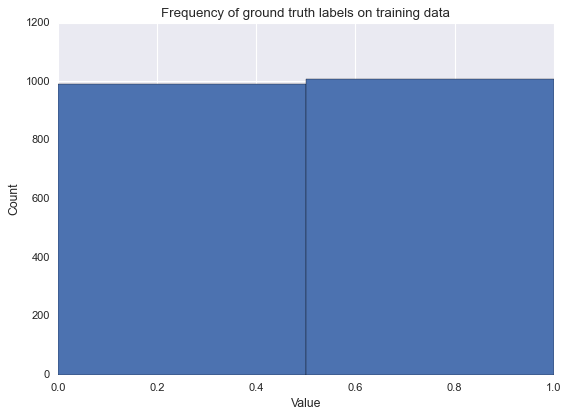

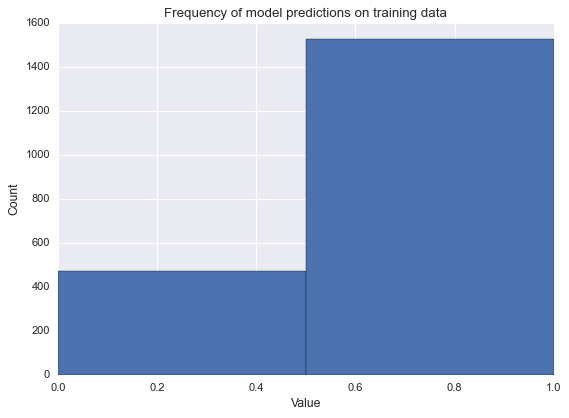

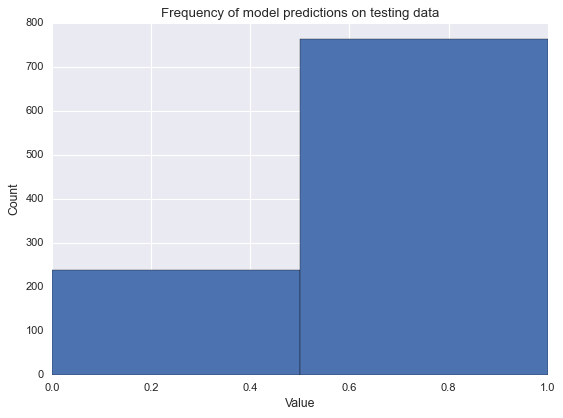

Last loss: 0.5656
Last train accuracy: 0.7410
Last test accuracy: 0.7240


In [12]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# NOTE: This method trains only once over all examples, updating the stats every 500 steps.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X,                      # Training inputs
    y,                      # Training Labels
    local_net,              # The BrainNet
    num_epochs = 10,
    batch_size = 1,
    vanilla = False,
    learn_rate = 1e-2,
    X_test = X_test,
    y_test = y_test,
    verbose = True)

In [13]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.5656
Last train accuracy: 0.7410
Last test accuracy: 0.7240


all_losses: (41,)
all_train_acc: (41,)
all_test_acc: (41,)
sample_counts: (41,)


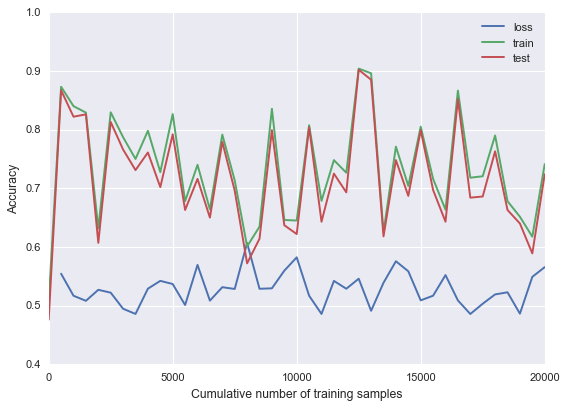

In [14]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Meta-learn rules on halfspace, train with fixed rules on MNIST

We create different upstream (halfspace) vs downstream (MNIST) network.

NOTE: the reason this doesn't work too well is because the actual procedures in the paper are a little more complicated, see **Appendix A.2**. I am using a halfspace dimension of 8 and MNIST is 28 x 28, and then the rules are copied across different networks.

Interestingly, even if the upstream accuracy is chance (50%), the downstream training still works sometimes...

In [15]:
options = LocalNetBase.Options(
    gd_input = True,          # GD directly on input layer weights.
    use_graph_rule = True,
    gd_graph_rule = True,
    use_output_rule = True,   # Use an output rule to update input layer weights.
    gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    gd_output = False,        # GD directly on output layer weights.
    additive_rule = True)     # If false, uses multiplicative updates.

# ==== TODO: improve this to match paper ====

# Initialize new network.
dimension = 8
local_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)

# Generate halfspace data.
n = 4000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X, y, local_net, num_rule_epochs=20, num_epochs=2, batch_size=100, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False)

100%|█████████| 20/20 [02:50<00:00,  8.51s/it]

Last loss: 0.6245
Last train accuracy: 0.4980
Last test accuracy: 0.4958


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


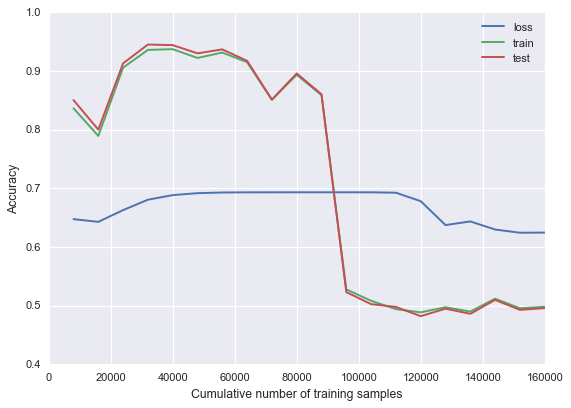

In [16]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Transfer rules to new model
dimension = 28 * 28
mnist_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 10,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
# mnist_net.set_rnn_rule(local_net.get_rnn_rule())
# mnist_net.set_output_rule(local_net.get_output_rule())
mnist_net.rnn_rule = local_net.rnn_rule
mnist_net.output_rule = local_net.output_rule

# Recall MNIST data.
X, y, X_test, y_test = mnist_X, mnist_y, mnist_X_test, mnist_y_test
X = X.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X, y, mnist_net, num_epochs=1, batch_size=1, vanilla=False, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=3000)

INITIAL train accuracy: 0.0902


  0%|               | 0/60000 [00:00<?, ?it/s]

INITIAL test accuracy: 0.0900
Epoch 1 / 1 ...


100%|██| 60000/60000 [05:28<00:00, 182.47it/s]


Last loss: 2.3096
Last train accuracy: 0.1052
Last test accuracy: 0.1050


all_losses: (21,)
all_train_acc: (21,)
all_test_acc: (21,)
sample_counts: (21,)


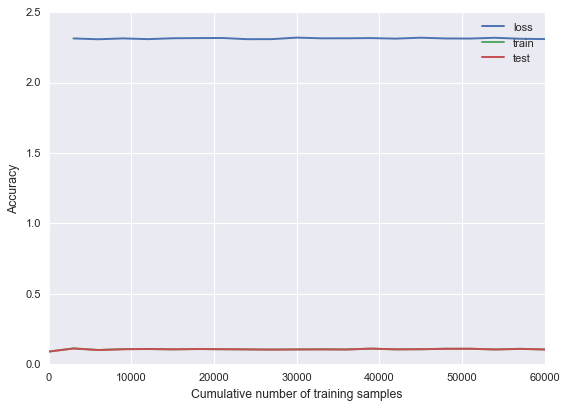

In [18]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()